# M/EEG exam instructions
- Assignment format: 
    - mandatory: a notebook with your answers 
    - optional: an additional document with your answers to the conceptual questions
- Please send your assignment to M.Corsi's email address
- Deadline: 
    - **Feb 22nd, 8AM.** Please not that an **extension will not be proposed.**

In [1]:
import matplotlib
# matplotlib.use('QtAgg')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.stats import permutation_cluster_1samp_test as pcluster_test
from mne.time_frequency import tfr_multitaper


## Part 1 - Connectivity and Networks

Here is an EEG dataset to load:

In [2]:
 
#Define the parameters
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # Motor imagery: hands vs feet

# Extract raw data
fnames = eegbci.load_data(subject=subject, runs=runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in fnames])
raw.rename_channels(lambda x: x.strip("."))  # remove dots from channel names
events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))
channel_names = raw.info['ch_names']

# Extract trials between -1s and 4s
tmin, tmax = -1, 4
event_ids = dict(hands=2, feet=3)  # map event IDs to tasks
epochs = mne.Epochs(
    raw,
    events,
    event_ids,
    tmin - 0.5,
    tmax + 0.5,
    baseline=None,
    preload=True,
)


Extracting EDF parameters from /storage/store3/work/pbarbara/ensae/M2-MVA_MEEG_hands-on_materials/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /storage/store3/work/pbarbara/ensae/M2-MVA_MEEG_hands-on_materials/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /storage/store3/work/pbarbara/ensae/M2-MVA_MEEG_hands-on_materials/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
N

Processing condition: hands


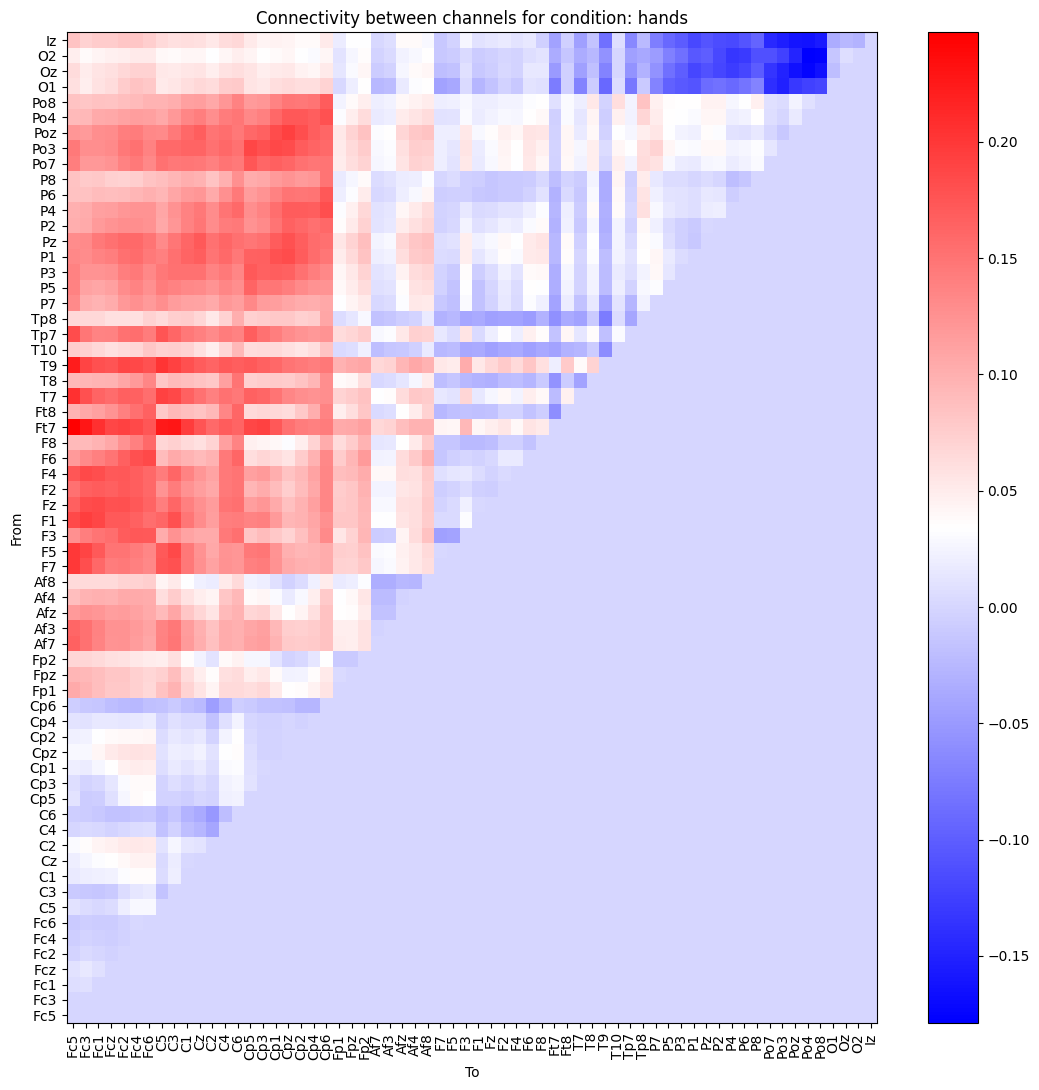

Processing condition: feet


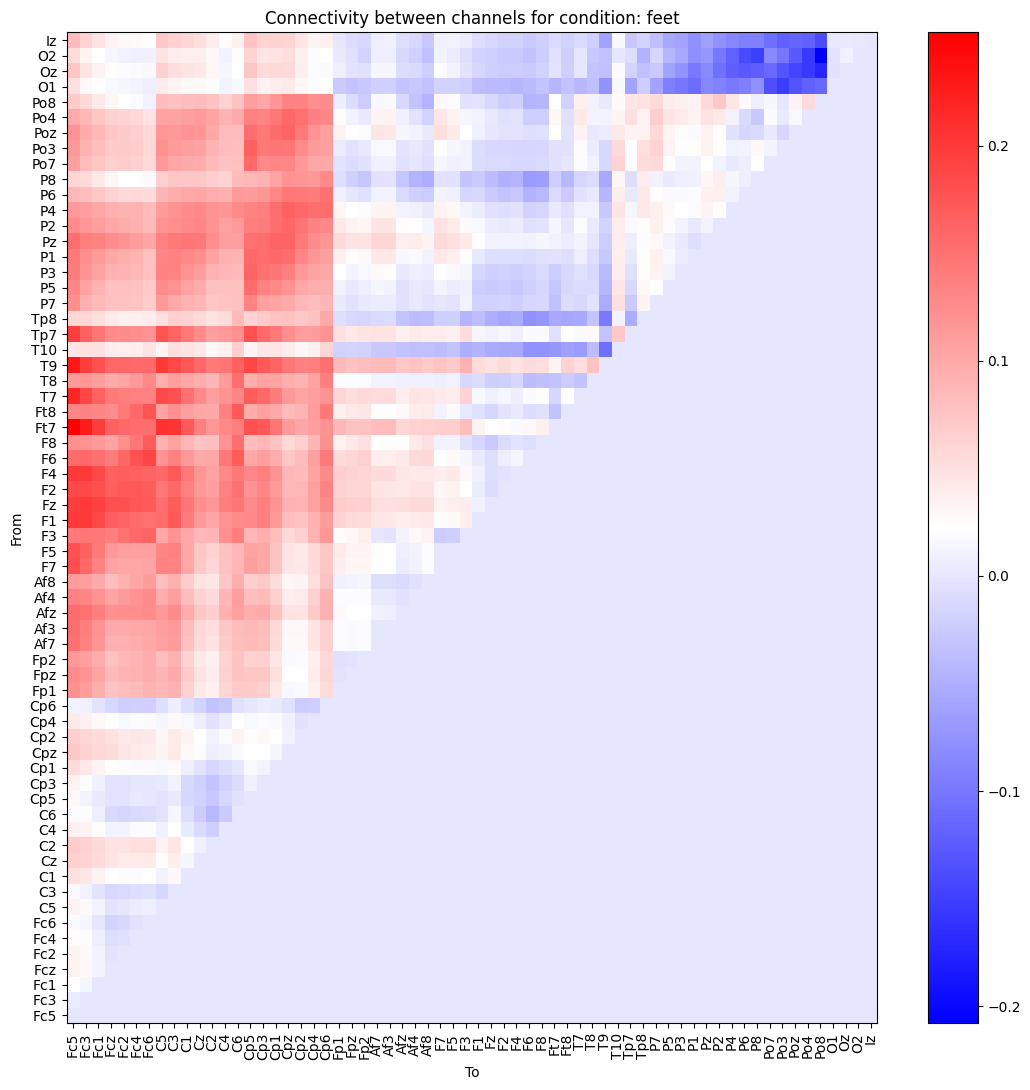

In [3]:
from mne_connectivity import spectral_connectivity_epochs
from mne_connectivity.viz import plot_connectivity_circle

for condition in event_ids.keys():
    print(f"Processing condition: {condition}")
    
    # Compute connectivity based on the imaginary coherence
    fmin, fmax = 8, 13  # keep only the mu frequency band
    sfreq = raw.info['sfreq']  # the sampling frequency
    con = spectral_connectivity_epochs(
        epochs[condition],
        method="imcoh", # compute the imaginary coherence
        mode="multitaper",
        sfreq=sfreq,
        fmin=fmin,
        fmax=fmax,
        faverage=True,
        verbose=False,
    )
    
    conmat = con.get_data(output="dense")[:, :, 0]
    
    # Plot connectivity as a matrix
    plt.figure(figsize=(11, 11))
    plt.imshow(conmat, cmap="bwr", origin="lower", aspect="auto")
    plt.colorbar()
    plt.title(f"Connectivity between channels for condition: {condition}")
    plt.xlabel("To")
    plt.ylabel("From")
    plt.xticks(np.arange(len(channel_names)), channel_names, rotation=90)
    plt.yticks(np.arange(len(channel_names)), channel_names)
    plt.tight_layout()
    plt.show()
    

Processing condition: hands


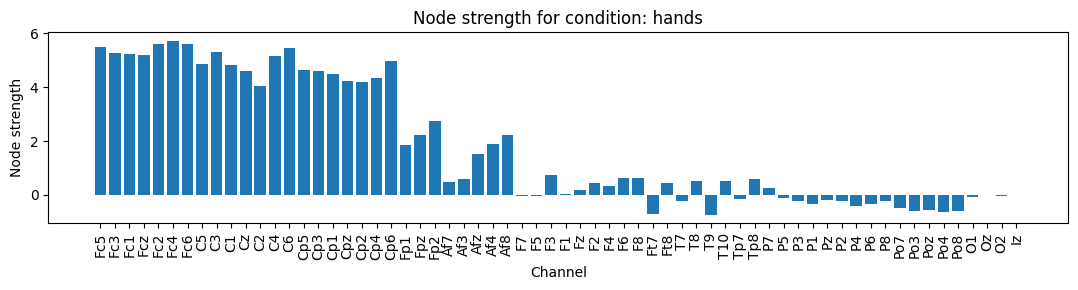

Processing condition: feet


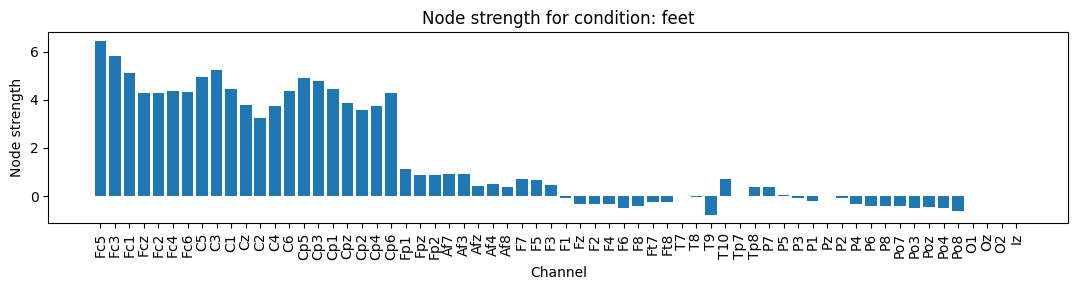

In [4]:
for condition in event_ids.keys():
    print(f"Processing condition: {condition}")
    
    # Compute connectivity based on the imaginary coherence
    fmin, fmax = 8, 13  # keep only the mu frequency band
    sfreq = raw.info['sfreq']  # the sampling frequency
    con = spectral_connectivity_epochs(
        epochs[condition],
        method="imcoh", # compute the imaginary coherence
        mode="multitaper",
        sfreq=sfreq,
        fmin=fmin,
        fmax=fmax,
        faverage=True,
        verbose=False,
    )
    
    conmat = con.get_data(output="dense")[:, :, 0]
    
    # Plot node strength
    node_strength = np.sum(conmat, axis=0)
    plt.figure(figsize=(11, 3))
    plt.bar(np.arange(len(channel_names)), node_strength)
    plt.title(f"Node strength for condition: {condition}")
    plt.xlabel("Channel")
    plt.ylabel("Node strength")
    plt.xticks(np.arange(len(channel_names)), channel_names, rotation=90)
    plt.tight_layout()
    plt.show()

## Questions:
- For each condition:
    - Compute and plot the connectivity matrices based on the estimation of the imaginary coherence averaged over the mu band and across the epochs. What does it say about potential changes between the tasks performed by the subject?
    - Compute and plot the associated node strength averaged across the epochs. What does it say about potential changes between the tasks performed by the subject?

- Here is the plot of the statistical difference between MI and Rest conditions obtained from imaginary coherence (left) and the results obtained with the node strength (right): What do you observe? Is it neurophysiologically meaningful?
![Figure_ImCoh](./MI_Rest_ImCoh.png)


## Part 2 - Features in BCI

Here is an EEG dataset to load:

Extracting EDF parameters from /storage/store3/work/pbarbara/ensae/M2-MVA_MEEG_hands-on_materials/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /storage/store3/work/pbarbara/ensae/M2-MVA_MEEG_hands-on_materials/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /storage/store3/work/pbarbara/ensae/M2-MVA_MEEG_hands-on_materials/datasets/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...


Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 961 original time points ...
0 bad epochs dropped
Not setting metadata
Applying baseline correction (mode: percent)
Using a threshold of 1.724718
stat_fun(H1): min=-4.138024 max=3.447988
Running initial clustering …
Found 77 clusters


/data/parietal/store3/work/pbarbara/anaconda3/envs/fugwenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| Permuting : 99/99 [00:00<00:00,  226.61it/s]


Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


100%|██████████| Permuting : 99/99 [00:00<00:00,  220.96it/s]

Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.724718
stat_fun(H1): min=-4.138024 max=3.447988
Running initial clustering …
Found 98 clusters



100%|██████████| Permuting : 99/99 [00:00<00:00,  216.52it/s]


Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.724718
stat_fun(H1): min=-8.552076 max=3.438133
Running initial clustering …
Found 113 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  219.64it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.724718
stat_fun(H1): min=-8.552076 max=3.438133
Running initial clustering …
Found 87 clusters



100%|██████████| Permuting : 99/99 [00:00<00:00,  212.22it/s]


Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


100%|██████████| Permuting : 99/99 [00:00<00:00,  212.32it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.724718
stat_fun(H1): min=-6.323372 max=5.715372
Running initial clustering …
Found 149 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  213.77it/s]


Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


100%|██████████| Permuting : 99/99 [00:00<00:00,  215.74it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.724718
stat_fun(H1): min=-6.323372 max=5.715372
Running initial clustering …
Found 77 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  198.96it/s]


Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied


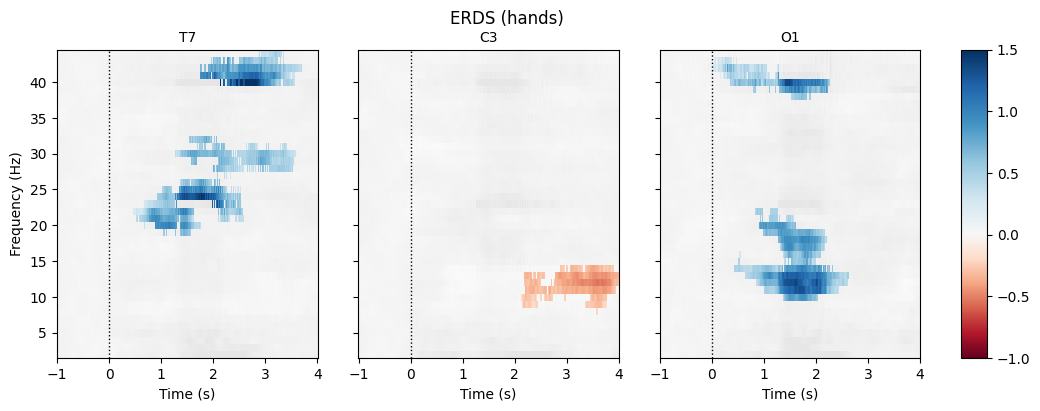

Using a threshold of 1.713872
stat_fun(H1): min=-5.649621 max=3.069908
Running initial clustering …
Found 63 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  207.82it/s]


Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.713872
stat_fun(H1): min=-5.649621 max=3.069908
Running initial clustering …
Found 80 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  207.71it/s]


Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.713872
stat_fun(H1): min=-3.754759 max=3.360704
Running initial clustering …
Found 116 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  203.11it/s]


Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
Using a threshold of -1.713872
stat_fun(H1): min=-3.754759 max=3.360704
Running initial clustering …
Found 113 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  209.24it/s]


Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied
Using a threshold of 1.713872
stat_fun(H1): min=-3.616018 max=3.513905
Running initial clustering …
Found 134 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  198.02it/s]


Step-down-in-jumps iteration #1 found 1 cluster to exclude from subsequent iterations


100%|██████████| Permuting : 99/99 [00:00<00:00,  197.86it/s]


Step-down-in-jumps iteration #2 found 0 additional clusters to exclude from subsequent iterations
Using a threshold of -1.713872
stat_fun(H1): min=-3.616018 max=3.513905
Running initial clustering …
Found 60 clusters


100%|██████████| Permuting : 99/99 [00:00<00:00,  203.72it/s]

Step-down-in-jumps iteration #1 found 0 clusters to exclude from subsequent iterations
No baseline correction applied


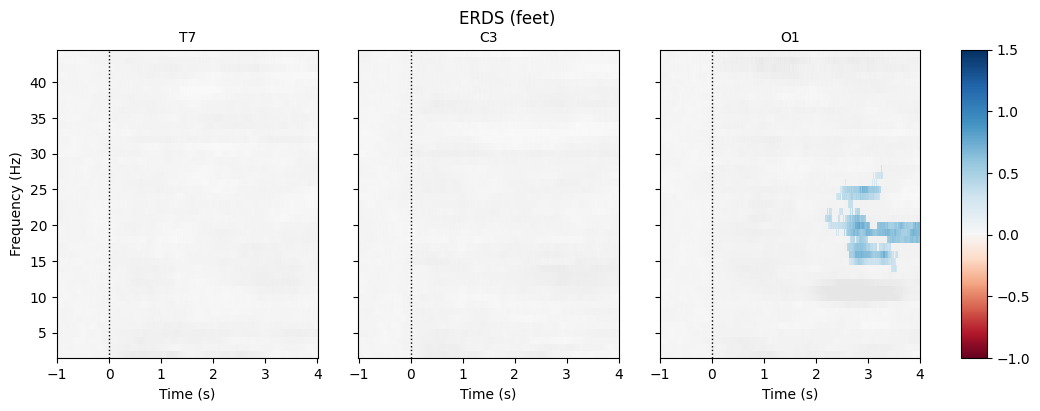

In [5]:
#Define the parameters
subject = 1  # use data from subject 1
runs = [6, 10, 14]  # Motor imagery: hands vs feet

# Extract raw data
fnames = eegbci.load_data(subject=subject, runs=runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in fnames])
raw.rename_channels(lambda x: x.strip("."))  # remove dots from channel names
events, _ = mne.events_from_annotations(raw, event_id=dict(T1=2, T2=3))

# Extract trials between -1s and 4s
channelsOfInterest = "T7", "C3", 'O1' # to get the full list of channels you can type: raw.info['ch_names']
tmin, tmax = -1, 4
event_ids = dict(hands=2, feet=3)  # map event IDs to tasks
epochs = mne.Epochs(
    raw,
    events,
    event_ids,
    tmin - 0.5,
    tmax + 0.5,
    picks=(channelsOfInterest),
    baseline=None,
    preload=True,
)

# Compare power spectra computed in each condition/channel 
freqs = np.arange(2, 45)
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-1, 0)  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS

kwargs = dict(
    n_permutations=100, step_down_p=0.05, seed=1, buffer_size=None, out_type="mask"
)  # for cluster test

# Time-Frequency decomposition
tfr = tfr_multitaper(
    epochs,
    freqs=freqs,
    n_cycles=freqs,
    use_fft=True,
    return_itc=False,
    average=False,
    decim=2,
)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

nb_channels = len(channelsOfInterest)
for event in event_ids:
    # select desired epochs for visualization
    tfr_ev = tfr[event]
    fig, axes = plt.subplots(
        1, 4, figsize=(12, 4), gridspec_kw={"width_ratios": [10, 10, 10, 1]}
    )
    for ch, ax in enumerate(axes[:-1]):  # for each channel
        # positive clusters
        _, c1, p1, _ = pcluster_test(tfr_ev.data[:, ch], tail=1, **kwargs)
        # negative clusters
        _, c2, p2, _ = pcluster_test(tfr_ev.data[:, ch], tail=-1, **kwargs)

        # note that we keep clusters with p <= 0.05 from the combined clusters
        # of two independent tests; in this example, we do not correct for
        # these two comparisons
        c = np.stack(c1 + c2, axis=2)  # combined clusters
        p = np.concatenate((p1, p2))  # combined p-values
        mask = c[..., p <= 0.05].any(axis=-1)

        # plot TFR (ERDS map with masking)
        tfr_ev.average().plot(
            [ch],
            cmap="RdBu",
            cnorm=cnorm,
            axes=ax,
            colorbar=False,
            show=False,
            mask=mask,
            mask_style="mask",
        )

        ax.set_title(epochs.ch_names[ch], fontsize=10)
        ax.axvline(0, linewidth=1, color="black", linestyle=":")  # event
        if ch != 0:
            ax.set_ylabel("")
            ax.set_yticklabels("")
    fig.colorbar(axes[0].images[-1], cax=axes[-1]).ax.set_yscale("linear")
    fig.suptitle(f"ERDS ({event})")
    plt.show()

## Questions: 
- Please describe the observations you can make from the maps. Are there neurophysiologically relevant/meaningful?
- To what extent such observations are informative of BCI performance?
- If you were the experimenter, based on the previous observations, which (electrode(s); frequency bin(s)) couples would you pick to extract the features? Why?

## Part 3 - Machine Learning & BCI

## Context

Here is a publicly available [BCI dataset](http://moabb.neurotechx.com/docs/generated/moabb.datasets.BNCI2014_001.html#moabb.datasets.BNCI2014_001) (cf below to load the data and to get information regarding the experimental information). In the following lines of code we defined two classification pipelines (CSP+LDA: Common Spatial Patterns + LDA, RG+LR:Riemannian Geometry + Logistic Regression), and we plotted their performances from a dataset composed of 2 subjects.

## Questions
- What observations can be made from the plots? 
- Instead of those implemented here, what framework would you propose to extract, select, and classify the features? Why? How would you assess the performance of your approach?

## BONUS
- Implement below your framework and compare it to the other pipelines (namely RG+LR and CSP+LDA). 
- What are your conclusions? Do you have some suggestion(s) to improve the performance of your framework?

In [64]:
import warnings

from mne.decoding import CSP
from pyriemann.estimation import Covariances
from pyriemann.tangentspace import TangentSpace
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.manifold import TSNE

import moabb
from moabb.datasets import BNCI2014001 # note: if you use MOABB>1.1, please change it as BNCI2014_001
from moabb.evaluations import WithinSessionEvaluation
from moabb.paradigms import LeftRightImagery

moabb.set_log_level("info")
mne.set_log_level("CRITICAL")
warnings.filterwarnings("ignore")


###### PIPELINES TO BE COMPARED (do not modify it!) ######
# baseline pipeline to be used to make the comparison, please complete the following line with your framework
pipelines = {}
pipelines["CSP+LDA"] = make_pipeline(CSP(n_components=8), LDA())
pipelines["RG+LR"] = make_pipeline(
    Covariances(), TangentSpace(), LogisticRegression(solver="lbfgs")
)
### BONUS - implementation of your framework ######
pipelines["MyPipeline"] = make_pipeline(
    Covariances(),
    TangentSpace(),
    StandardScaler(), # Standardize features by removing the mean and scaling to unit variance
    SVC(kernel="rbf", C=1),  # Gaussian kernel SVM
)


###### DATASET TO BE USED (do not modify it!) - downloading it the first time can take some time ######
dataset = BNCI2014001() # if you are using a more recent version of moabb please change it as BNCI2014_001
subj = [1, 2]
dataset.subject_list = subj


###### DEFINITION OF THE PARADIGM & EVALUATION (do not modify it!) ######
paradigm = LeftRightImagery()
evaluation = WithinSessionEvaluation(
    paradigm=paradigm, datasets=dataset, overwrite=False
)
results = evaluation.process(pipelines)
print(results.head()) # if you want to look at it...


2024-02-20 20:07:41,642 WARNING MainThread moabb.utils BNCI2014001 has been renamed to BNCI2014_001. BNCI2014001 will be removed in version 1.1.
2024-02-20 20:07:41,644 WARNING MainThread moabb.datasets.base The dataset class name 'BNCI2014001' must be an abbreviation of its code 'BNCI2014-001'. See moabb.datasets.base.is_abbrev for more information.
2024-02-20 20:07:41,646 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-WithinSession:   0%|          | 0/2 [00:00<?, ?it/s]


      score      time  samples subject session  channels  n_sessions  \
0  0.954286  0.168277    144.0       1  0train        22           2   
1  0.969388  0.167383    144.0       1   1test        22           2   
2  0.739932  0.171807    144.0       2  0train        22           2   
3  0.663197  0.167333    144.0       2   1test        22           2   
4  0.967007  0.169409    144.0       1  0train        22           2   

        dataset    pipeline  
0  BNCI2014-001  MyPipeline  
1  BNCI2014-001  MyPipeline  
2  BNCI2014-001  MyPipeline  
3  BNCI2014-001  MyPipeline  
4  BNCI2014-001       RG+LR  


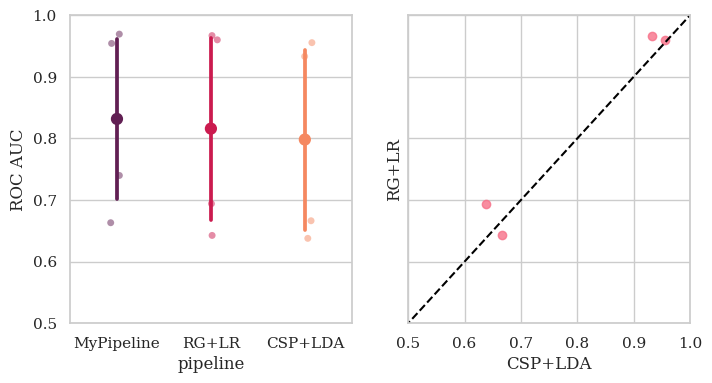

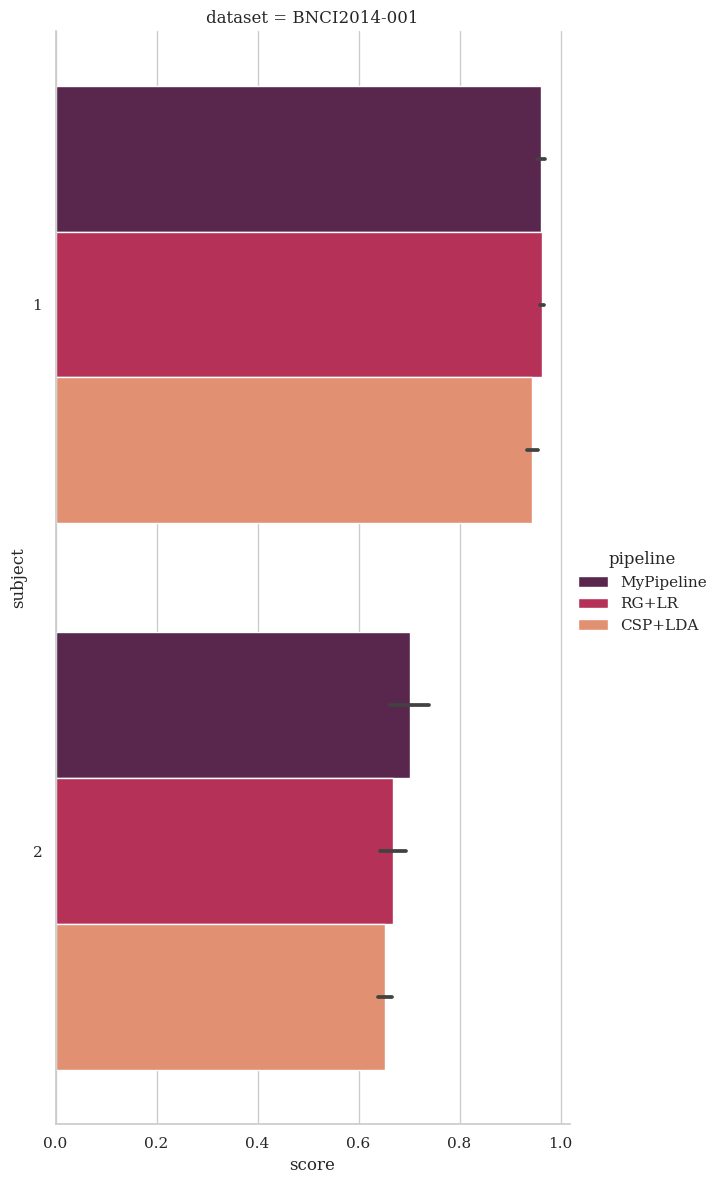

In [65]:
###### SCRIPT TO PLOT THE RESULTS (do not modify it unless you want to add your framework!) #########

# Plot the global distribution of the performance
fig, axes = plt.subplots(1, 2, figsize=[8, 4], sharey=True)

sns.stripplot(
    data=results,
    y="score",
    x="pipeline",
    ax=axes[0],
    jitter=True,
    alpha=0.5,
    zorder=1,
    palette="rocket",
)
sns.pointplot(data=results, y="score", x="pipeline", ax=axes[0], palette="rocket")

axes[0].set_ylabel("ROC AUC")
axes[0].set_ylim(0.5, 1)

paired = results.pivot_table(
    values="score", columns="pipeline", index=["subject", "session"]
)
paired = paired.reset_index()

sns.regplot(data=paired, y="RG+LR", x="CSP+LDA", ax=axes[1], fit_reg=False)
axes[1].plot([0, 1], [0, 1], ls="--", c="k")
axes[1].set_xlim(0.5, 1)

plt.show()

# Plot the individual distribution of the performance
g = sns.catplot(
    kind="bar",
    x="score",
    y="subject",
    hue="pipeline",
    col="dataset",
    height=12,
    aspect=0.5,
    data=results,
    orient="h",
    palette="rocket",
)
plt.show()

## Part 4 - Experimental considerations

You plan to launch a new protocol based on EEG acquisitions:
- What are the two main types of artifacts you may observe? Please indicate one example for each of them.
- What are the main steps that compose an EEG processing pipeline?

Now you are conducting and experimental protocol in BCI. It consists in 5 sessions of right hand motor imagery vs rest. After the fourth session training sessions subject Y still shows a global performance of 60%. 
At each session:
- You instructed the subject to perform a right motor imagery when the visual target was up and to remain at rest when the visual target was down.
- You always selected the same features (power spectra in CP3 at 10Hz & 14Hz, and in C3 at 12Hz & 16Hz).

Based on these elements, what would be your suggestions to help the subject Y improving their performance at session 5?